### Ultimate Take Home Project

#### Part 1 - Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
import json
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import rcParams

In [2]:
logins = pd.read_json('logins.json')

In [3]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins['counts'] = 1
logins.index = pd.DatetimeIndex(logins.login_time)
logins.index.name = None
logins.drop('login_time', axis=1,inplace = True)
login_15 = logins.resample("15T").count()

In [5]:
login_15.head()

,counts
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


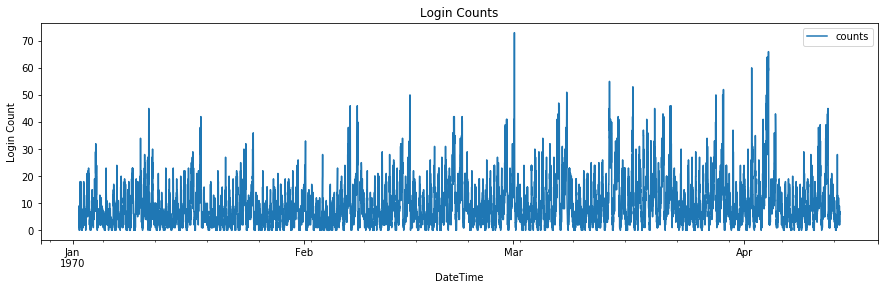

In [6]:
login_15.plot(figsize=(15,4))
plt.title('Login Counts')
plt.xlabel('DateTime')
plt.ylabel('Login Count')
plt.show()

It looks like there is a pattern of building to a weekly peak, with spikes each day as well.  There is also an overall trend upward.

In [7]:
intervals_per_day = int(24 * 60 / 15)
intervals_per_week = intervals_per_day * 7
print(intervals_per_day)
print(intervals_per_week)

96
672


First I will plot the first week to see what it looks like.

In [8]:
first_week = login_15.iloc[:intervals_per_week]

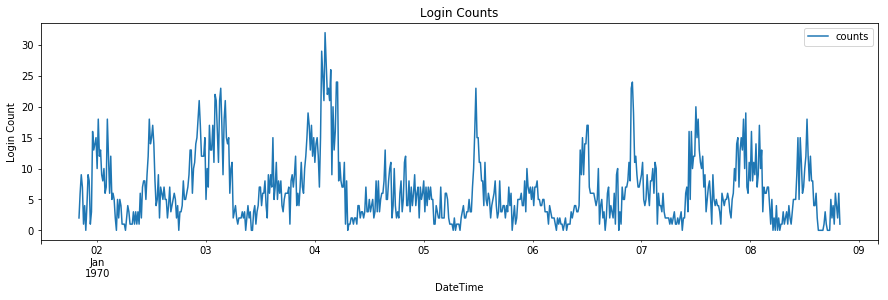

In [9]:
first_week.plot(figsize=(15,4))
plt.xticks(rotation = 45)
plt.title('Login Counts')
plt.xlabel('DateTime')
plt.ylabel('Login Count')
plt.show()

In [10]:
first_week[first_week.counts == first_week.counts.max()]

,counts
1970-01-04 02:15:00,32


In [11]:
first_week[first_week.counts == 32].index.dayofweek

Int64Index([6], dtype='int64')

The peak during the first week was the 4th at 2:15 AM, which is a early on Sunday morning.  Other peaks occur around mid-day, and there is a peak late in the day on the 6th, which is a Tuesday.

In [12]:
rcParams['figure.figsize'] = 15, 4

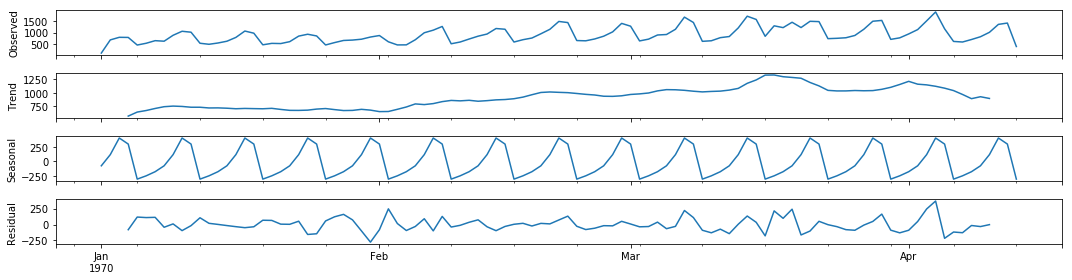

In [13]:
decomposition = sm.tsa.seasonal_decompose(logins.resample('24H').sum())

decomposition.plot()
plt.show()

The seasonal decomposiotion shows the weekly trend of building to a peak each weak and dropping off, as well as the upward trend, which reverses around the middle of March.



In [14]:
login_15['day_of_week'] = pd.DatetimeIndex(login_15.index).dayofweek
login_15['hour'] = pd.DatetimeIndex(login_15.index).hour

In [15]:
day_pivot = pd.pivot_table(data = login_15, values = 'counts', index = 'day_of_week', aggfunc = 'sum')
hour_pivot = pd.pivot_table(data = login_15, values = 'counts', index = 'hour', aggfunc = 'sum')

In [16]:
day_pivot

,counts
day_of_week,
0,8823
1,9268
2,10339
3,11960
4,15208
5,19377
6,18167


Mondays have the fewest logins.  Logins build as throughout the week and peak during the weekends, with Saturdays having the most logins.

In [17]:
hour_pivot

,counts
hour,
0,5993
1,6317
2,5800
3,4831
4,5034
5,2945
6,1138
7,815
8,818


On a daily basis, logins have two peaks: one peak is from 10:00 PM to 2:00AM, and the other from 11:00 AM to 1:00 PM

### Part 2 - Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment

b. what statistical test(s) you will conduct to verify the significance of the
observation

c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


#### Answer

1)

I would first look at the number of trips through the toll station of driver partners before and after making the toll "free" to driver partners.  I would choose this metric because it would be fairly eawy to measure and implement, and would show the difference, if any, of the number of intercity trips by driver partners before and after making it free for them.


2)

I would implement this experiment by counting the number of driver partners passing through the toll booth  before and after the reveral of the fees.  Care should be taken to make sure the before and after do not have any other factors that would affect the result.  For example, the measured periods should be about the same length and cover an equal number of weekday and weekend days.  Also, the free period would nee to be sufficiently long to get the word out.  If it is only for a few days and the public doesn't have time to learn of the free tolls and react to it, it will minimize the effect.

A hypothesis test can be set up with the null hypothesis that there is no difference in the number of driver partner cars passing through the toll booths before and after implementing the free period. The difference in number of trips can be calculated, and t-test or z-test can be used to calculate the probability that the observed difference happened by chance. It is also possible to combine the before and after sample and run a permutation test to calculated a p-value. 

If the p-value below the significance level, the null hyopothesis can be rejected, and I would recommend to the city that reversing the tolls for driver partners has a significant probability of increasing inter-city travel.  I would offer the caveat that it may take the bublic a long time to respond, so the effect of removing the tolls may ultimitely be even greater than the observed difference.



### Part 3 Predictive Modeling


Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

#### Read and explore the Data

In [22]:
with open("ultimate_data_challenge.json") as f:
    rider_data = json.load(f)

rider_data = pd.DataFrame(pred_data)
rider_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [23]:
rider_data.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [32]:
rider_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


There are missing values in `avg_rating_by_driver`, `avg_rating_of_driver`, and `phone` variables.

The average vataing metrics are continous, and I will replace missing values with the median, while phone is a categorical, which I will replace with a third category "unknown".

In [28]:
rider_data.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [30]:
rider_data['avg_rating_of_driver'].fillna(rider_data['avg_rating_of_driver'].median(), inplace = True)

In [31]:
rider_data['avg_rating_by_driver'].fillna(rider_data['avg_rating_by_driver'].median(), inplace = True)

In [ ]:
for col in null_cols:
    loans[col].fillna(loans[col].median(), inplace = True)

#### Predictive Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier



#### Insights